# Renting in Chicago, IL

## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

In this project we will try to identify safe and inexpensive places to rent apartments in **Chicago, IL**. This project is targeted towards a young professional looking for an apartment to live in the city. 

Finding a neighbourhood that is safe and also inexpensive can be tricky. Especially, in big cities like Chicago. For the purposes of this project, I will focus on prices of apartments and frequency of crime.

## Data <a name="data"></a>

To identify low-frequency of crime neighbourhoods we will need the following data:
* Crime data by zipcode
* Apartment rental data 

We will extract **Crime Rate** data for each zipcode from **City of Chicago Data Portal**
* This data includes the number of crime incidents for a specific latitude & Longitude 


We will define our neighborhoods by their **Zipcode** which is obtained with **GeoPy's Reverse Geocoding** from coordinates obtained from the Crime data. 


#### Import & Install Libraries

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(['ggplot'])
import requests
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans


In [3]:
! pip install folium

In [2]:
import folium

### Data Acquisition & Cleaning


In [4]:
#scrape Chicago rental data from Zillow

from bs4 import BeautifulSoup
import csv



class ZillowScraper:
    results = []

    headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'no-cache',
        'cookie': 'zguid=23|%2403435e76-0699-4a32-b86d-77d033c907ef; _ga=GA1.2.1271511001.1575011821; zjs_user_id=null; zjs_anonymous_id=%2203435e76-0699-4a32-b86d-77d033c907ef%22; _gcl_au=1.1.1333357279.1575011822; _pxvid=3cfcc163-1278-11ea-bff8-0242ac12000b; ki_r=; __gads=ID=84d8013cfac6df96:T=1575012041:S=ALNI_MaSvVNZsir2JXJ17pv54bjsPuyfcw; ki_s=199442%3A0.0.0.0.0%3B199444%3A0.0.0.0.2; zgsession=1|c0999376-b167-4a47-a1cd-0e456d882d4e; _gid=GA1.2.55965867.1578668946; JSESSIONID=87D0662A6BC141A73F0D12620788519C; KruxPixel=true; DoubleClickSession=true; KruxAddition=true; ki_t=1575011869563%3B1578669044158%3B1578669044158%3B2%3B10; _pxff_tm=1; _px3=2e6809e35ce7e076934ff998c2bdb8140e8b793b53e08a27c5da11f1b4760755:DFItCmrETuS2OQcztcFmt0FYPUn00ihAAue2ynQgbfSq6H+p2yP3Rl3aeyls3Unr1VRJSgcNue8Rr1SUq4P1jA==:1000:9ueZvAJ6v5y4ny7psGF25dK+d3GlytY2Bh+Xj9UUhC4DaioIZ+FMXPU0mOX+Qnghqut0jIT61gLecN4fyu6qXaPDlBX6YsZVbIry1YyBN/37l0Ri3JP+E0h+m+QEBB+bqb6MbE2HtgGBJRJAry8dgOKGM5JtBGdX+X/nuQX1xaw=; AWSALB=E6JYC43gXQRlE2jPT9e2vAQOYPvdHnccBlqi0mcXevYExTaHro0M+uo/Qxahi6JyLz9LpotY9eLtEbYrAOeQXcCm6UhjWnTopQHernmjlR/ibE6JmE8F6tReiBn4; search=6|1581261153229%7Crect%3D40.96202658306895%252C-73.55498286718745%252C40.4487909557045%252C-74.40093013281245%26rid%3D6181%26disp%3Dmap%26mdm%3Dauto%26p%3D3%26z%3D0%26lt%3Dfsbo%26pt%3Dpmf%252Cpf%26fs%3D1%26fr%3D0%26mmm%3D1%26rs%3D0%26ah%3D0%26singlestory%3D0%26housing-connector%3D0%26abo%3D0%26garage%3D0%26pool%3D0%26ac%3D0%26waterfront%3D0%26finished%3D0%26unfinished%3D0%26cityview%3D0%26mountainview%3D0%26parkview%3D0%26waterview%3D0%26hoadata%3D1%26zillow-owned%3D0%09%01%096181%09%09%09%090%09US_%09',
        'pragma': 'no-cache',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/75.0.3770.142 Chrome/75.0.3770.142 Safari/537.36'
    }

    def fetch(self, url, params):
        print('HTTP GET request to URL: %s' % url, end='')
        res = requests.get(url, params=params, headers=self.headers)
        print(' | Status code: %s' % res.status_code)
        
        return res
   
    def save_response(self, res):
        with open('res.html', 'w') as html_file:
            html_file.write(res)

    def load_response(self):
        html = ''
        
        with open('res.html', 'r') as html_file:
            for line in html_file:
                html += line
        
        return html
   
    def parse(self, html):
        # parse response
        content = BeautifulSoup(html, 'lxml')
        
        # extract property cards
        cards = content.findAll('article', {'class': 'list-card'})
        
        # extract coordinates script
        script = content.find('script', {'data-zrr-shared-data-key': 'mobileSearchPageStore'}).string

    
        # loop over property cards
        for card in cards:
            # try to extract image
            try:
                image = card.find('div', {'class': 'list-card-top'}).find('img')['src']
            except:
                image = 'N/A'
                
            # extract items
            items = {
                'url': card.find('a', {'class': 'list-card-link'})['href'],
                'details': [
                            price.text for price in
                            card.find('ul', {'class': 'list-card-details'}).find_all('li')
                          ],
                'address': card.find('address', {'class': 'list-card-addr'}).text,
#                 'image': image
            }
            
            # try to extract price if not extracted yet
            try:
                items['price'] = card.find('div', {'class': 'list-card-price'}).text

            except:
                pass
            
            # try to extract coordinates from script
            try:
                
                splitter = '"detailUrl":"' + items['url'] + '","latLong":'
               
                
#                 blah = script.split(splitter)
#                 blah2 = blah[-1]
#                 blah3 = blah2.split('},')
#                 blah4 = blah3[0]
#                 totalblah = blah4 + '}'
                
         
# #                 print(blah2)
# #                 print(blah3)
# #                 print(blah4)                
# #                 print(totalblah)


                coords = json.loads(script.split(splitter)[-1].split('},')[0] + '}')
                items['coordinates'] = coords
               
#                 print(coords)
                
            except:
                coords = script.split(splitter)[-1].split('},')[0] + '}'
                splitter = '<!--{"queryState":{"mapBounds":'
                
                try:
                    map_bounds = json.loads(coords.split(splitter)[-1])
                    items['coordinates'] = map_bounds
                except:
                     continue
            

            # append scraped items to results list
#             if items['coordinates'] == 'N/A':
#                 continue
                
            self.results.append(items)
            print(json.dumps(items, indent=2))
    
    def to_json(self):
        with open('zillow_rent.json', 'w') as f:
            f.write(json.dumps(self.results, indent=2))
        
    def run(self):
        for page in range(1, 2):
            params = {
                'searchQueryState': '{"pagination":{"currentPage":%s},"usersSearchTerm":"Chicago, IL","mapBounds":{"west":-88.09607811914063,"east":-87.36823388085938,"south":41.606969127843165,"north":42.060251786677156},"regionSelection":[{"regionId":17426,"regionType":6}],"isMapVisible":false,"filterState":{"pmf":{"value":false},"fore":{"value":false},"auc":{"value":false},"nc":{"value":false},"fr":{"value":true},"fsbo":{"value":false},"cmsn":{"value":false},"pf":{"value":false},"fsba":{"value":false}},"isListVisible":true}' % str(page)
            }
            res = self.fetch('https://www.zillow.com/homes/Chicago,-IL_rb/?', params)
            self.parse(res.text)

        self.to_json()
        
        #html = self.load_response()
        #self.parse(html)
        

if __name__ == '__main__':
    scraper = ZillowScraper()
    scraper.run()


HTTP GET request to URL: https://www.zillow.com/homes/Chicago,-IL_rb/? | Status code: 200
{
  "url": "https://www.zillow.com/b/536-w-arlington-pl-chicago-il-5XgB2t/",
  "details": [
    "$915+ Studio",
    "$1,215 1 bd",
    "$2,250 2 bds"
  ],
  "address": "536 W Arlington Pl, Chicago, IL",
  "coordinates": {
    "latitude": 41.927077,
    "longitude": -87.642746
  }
}
{
  "url": "https://www.zillow.com/b/1200-w-monroe-st-chicago-il-5XjDCz/",
  "details": [
    "$2,100+ 1 bd",
    "$2,500+ 2 bds",
    "$4,500 3 bds"
  ],
  "address": "1200 W Monroe St, Chicago, IL",
  "coordinates": {
    "latitude": 41.881064,
    "longitude": -87.657427
  }
}
{
  "url": "https://www.zillow.com/b/247-e-chestnut-st-chicago-il-9nNq/",
  "details": [
    "$1,900+ 2 bds"
  ],
  "address": "247 E Chestnut St, Chicago, IL",
  "coordinates": {
    "latitude": 41.89829,
    "longitude": -87.620014
  }
}
{
  "url": "https://www.zillow.com/b/125-s-green-st-chicago-il-DDqn/",
  "details": [
    "$2,200+ 1 bd",


In [6]:


chicago_df = pd.read_json('C:/Users/zhiyi/coding/IBM_coursera/zillow_rent.json')

#separate price details column

for i in [0]:
    chicago_df['price{}'.format(str(i+1))] = [k[i] if isinstance(k,list) else k for k in chicago_df['details']]
    
chicago_df[['latitude','longitude']] = chicago_df['coordinates'].apply(pd.Series)


#SPLIT
chicago_df[['price', 'rooms']] = chicago_df.price1.apply(lambda x: pd.Series(str(x).split("+")))

#SPLIT address
# chicago_df[['address1', 'address2']] = chicago_df.address.apply(lambda x: pd.Series(str(x).split("|")))



#DROP

chicago_df = chicago_df[chicago_df.columns.drop('details')]
chicago_df = chicago_df[chicago_df.columns.drop('url')]
chicago_df = chicago_df[chicago_df.columns.drop('coordinates')]
chicago_df = chicago_df[chicago_df.columns.drop('price1')]

#combine ADDRESS, PRICE, and ROOMS to create new details

chicago_df["details"] = chicago_df["address"] + " " + chicago_df["price"] + " " + chicago_df["rooms"]


chicago_df


address   latitude  longitude  \
0                    2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                      2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3       620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   
..                                                 ...        ...        ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...  41.929058 -87.643767   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...  41.877635 -87.658137   
210  North Park Pointe | 1552 N North Park Ave, Chi...  41.910847 -87.636722   
211          Logan | 2480 N Milwaukee Ave, Chicago, IL  41.926316 -87.703411   
212  Luxe on Chicago | 1838 W Chicago Ave, Chicago, IL  41.896113 -87.673155   

             price    rooms                                            details  
0           $1,950    2 bds    2322 N Southport Ave, Chicago, IL $1,950  2 bds  
1           $1,200     1 bd       2566 N Lincoln Ave, Chicago, IL $1,200  1 bd  
2           $1,735     1 bd  Roosevelt Collection Lofts | 1135 S Delano Ct,...  
3             $925   Studio  620 W Belmont | 620 W Belmont Ave, Chicago, IL...  
4             $955   Studio  2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  
..             ...      ...                                                ...  
208         $1,325   Studio  625 W Wrightwood | 625 W Wrightwood Ave, Chica...  
209         $2,145     1 bd  Reside on Jackson | 1245 W Jackson Blvd, Chica...  
210         $2,013     1 bd  North Park Pointe | 1552 N North Park Ave, Chi...  
211         $1,746     1 bd  Logan | 2480 N Milwaukee Ave, Chicago, IL $1,7...  
212  $1,750 Studio      NaN                                                NaN  

[213 rows x 6 columns]

In [7]:
#import zipcode search
from uszipcode.search import SearchEngine
search = SearchEngine(simple_zipcode=True)
from uszipcode import Zipcode
import numpy as np

#define zipcode search function
def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, radius=25.0, returns = 1)
    return result[0].zipcode

#load columns from dataframe
lat = chicago_df["latitude"]
lon = chicago_df["longitude"]

df = pd.DataFrame({"lat":lat, "lon":lon})

#add new column with generated zip-code
chicago_df["zipcode"] = df.apply(lambda x: get_zipcode(x.lat, x.lon), axis=1)

chicago_df


address   latitude  longitude  \
0                    2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                      2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3       620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   
..                                                 ...        ...        ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...  41.929058 -87.643767   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...  41.877635 -87.658137   
210  North Park Pointe | 1552 N North Park Ave, Chi...  41.910847 -87.636722   
211          Logan | 2480 N Milwaukee Ave, Chicago, IL  41.926316 -87.703411   
212  Luxe on Chicago | 1838 W Chicago Ave, Chicago, IL  41.896113 -87.673155   

             price    rooms  \
0           $1,950    2 bds   
1           $1,200     1 bd   
2           $1,735     1 bd   
3             $925   Studio   
4             $955   Studio   
..             ...      ...   
208         $1,325   Studio   
209         $2,145     1 bd   
210         $2,013     1 bd   
211         $1,746     1 bd   
212  $1,750 Studio      NaN   

                                               details zipcode  
0      2322 N Southport Ave, Chicago, IL $1,950  2 bds   60614  
1         2566 N Lincoln Ave, Chicago, IL $1,200  1 bd   60614  
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...   60605  
3    620 W Belmont | 620 W Belmont Ave, Chicago, IL...   60613  
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...   60614  
..                                                 ...     ...  
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...   60614  
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...   60607  
210  North Park Pointe | 1552 N North Park Ave, Chi...   60610  
211  Logan | 2480 N Milwaukee Ave, Chicago, IL $1,7...   60647  
212                                                NaN   60642  

[213 rows x 7 columns]

In [5]:
#import crime data

crimes = pd.read_csv ('C:/Users/zhiyi/Documents/github/Chicago_rent/Chicago_rentals/chicago_crime.csv')

#extract zipcode
crimes['zipcodefinal'].astype(str)
crimes['zipcodefinal']=crimes['zipcodefinal'].str.split("'").str[1]

crimes


Unnamed: 0  Unnamed: 0.1        ID Case Number  \
0                0             0  12111314    JD303733   
1                1             1  12111648    JD304318   
2                2             2  12111917    JD304461   
3                3             3  12112346    JD303946   
4                4             4  12112815    JD304087   
...            ...           ...       ...         ...   
112842      112842        112842  11940534    JD100083   
112843      112843        112843  11938186    JD100178   
112844      112844        112844  11938654    JD100726   
112845      112845        112845  11938353    JD100252   
112846      112846        112846  11939683    JD101917   

                          Date                 Block  IUCR       Primary Type  \
0       07/20/2020 10:55:00 AM   104XX S CORLISS AVE  143A  WEAPONS VIOLATION   
1       07/20/2020 07:00:00 PM  025XX W WINNEMAC AVE  0620           BURGLARY   
2       07/20/2020 10:25:00 PM   016XX N KOSTNER AVE  041A            BATTERY   
3       07/20/2020 01:51:00 PM  062XX S ARTESIAN AVE  0479            BATTERY   
4       07/20/2020 04:30:00 PM   001XX N CENTRAL AVE  0560            ASSAULT   
...                        ...                   ...   ...                ...   
112842  01/01/2020 01:24:00 AM    062XX S WHIPPLE ST  0486            BATTERY   
112843  01/01/2020 03:00:00 AM      002XX N PINE AVE  0486            BATTERY   
112844  01/01/2020 02:13:00 PM   054XX N SHERIDAN RD  0486            BATTERY   
112845  01/01/2020 04:07:00 AM     068XX S PERRY AVE  0486            BATTERY   
112846  01/01/2020 03:00:00 PM  015XX W WABANSIA AVE  0560            ASSAULT   

                                            Description Location Description  \
0                         UNLAWFUL POSSESSION - HANDGUN               STREET   
1                                        UNLAWFUL ENTRY   RESIDENCE - GARAGE   
2                                  AGGRAVATED - HANDGUN               STREET   
3       AGGRAVATED - HANDS, FISTS, FEET, SERIOUS INJURY               STREET   
4                                                SIMPLE            APARTMENT   
...                                                 ...                  ...   
112842                          DOMESTIC BATTERY SIMPLE            APARTMENT   
112843                          DOMESTIC BATTERY SIMPLE            APARTMENT   
112844                          DOMESTIC BATTERY SIMPLE            RESIDENCE   
112845                          DOMESTIC BATTERY SIMPLE            APARTMENT   
112846                                           SIMPLE            APARTMENT   

        ...  X Coordinate  Y Coordinate  Year              Updated On  \
0       ...     1183422.0     1835942.0  2020  07/27/2020 03:57:04 PM   
1       ...     1158469.0     1933392.0  2020  07/27/2020 03:57:04 PM   
2       ...     1146775.0     1910296.0  2020  07/27/2020 03:57:04 PM   
3       ...     1161107.0     1863312.0  2020  07/27/2020 03:57:04 PM   
4       ...     1139025.0     1900507.0  2020  07/27/2020 03:57:04 PM   
...     ...           ...           ...   ...                     ...   
112842  ...     1157124.0     1863026.0  2020  01/08/2020 03:49:48 PM   
112843  ...     1139459.0     1901141.0  2020  01/08/2020 03:49:48 PM   
112844  ...     1168658.0     1936265.0  2020  01/08/2020 03:49:48 PM   
112845  ...     1176578.0     1859630.0  2020  01/08/2020 03:49:48 PM   
112846  ...     1165578.0     1911394.0  2020  01/08/2020 03:49:48 PM   

         Latitude  Longitude                       Location        lat  \
0       41.705013 -87.603940    (41.7050135, -87.603940179)  41.705013   
1       41.972971 -87.692654  (41.972971074, -87.692653538)  41.972971   
2       41.909826 -87.736247   (41.90982557, -87.736246746)  41.909826   
3       41.780611 -87.684900  (41.780610645, -87.684899958)  41.780611   
4       41.883108 -87.764956  (41.883107866, -87.764955649)  41.883108   
...           ...        ...                            

In [6]:
#drop NaN values
crimes=crimes.dropna(subset=['Longitude'])

crimes=crimes.dropna(subset=['Latitude'])

In [7]:
# get the first 1000 crimes in the df_incidents dataframe
limit = 5000
crimes = crimes.iloc[0:limit, :]

crimes

Unnamed: 0  Unnamed: 0.1        ID Case Number                    Date  \
0              0             0  12111314    JD303733  07/20/2020 10:55:00 AM   
1              1             1  12111648    JD304318  07/20/2020 07:00:00 PM   
2              2             2  12111917    JD304461  07/20/2020 10:25:00 PM   
3              3             3  12112346    JD303946  07/20/2020 01:51:00 PM   
4              4             4  12112815    JD304087  07/20/2020 04:30:00 PM   
...          ...           ...       ...         ...                     ...   
5219        5219          5219  12105324    JD296561  07/13/2020 11:28:00 PM   
5220        5220          5220  12105325    JD295436  07/13/2020 12:30:00 AM   
5221        5221          5221  12104358    JD295451  07/13/2020 12:57:00 AM   
5223        5223          5223  12104924    JD296290  07/13/2020 05:45:00 PM   
5224        5224          5224  12105062    JD296422  07/13/2020 06:00:00 PM   

                     Block  IUCR       Primary Type  \
0      104XX S CORLISS AVE  143A  WEAPONS VIOLATION   
1     025XX W WINNEMAC AVE  0620           BURGLARY   
2      016XX N KOSTNER AVE  041A            BATTERY   
3     062XX S ARTESIAN AVE  0479            BATTERY   
4      001XX N CENTRAL AVE  0560            ASSAULT   
...                    ...   ...                ...   
5219     081XX S LAFLIN ST  1320    CRIMINAL DAMAGE   
5220      058XX W HURON ST  0810              THEFT   
5221     087XX S DANTE AVE  051A            ASSAULT   
5223       001XX W 70TH ST  0810              THEFT   
5224    027XX W CARMEN AVE  0820              THEFT   

                                          Description    Location Description  \
0                       UNLAWFUL POSSESSION - HANDGUN                  STREET   
1                                      UNLAWFUL ENTRY      RESIDENCE - GARAGE   
2                                AGGRAVATED - HANDGUN                  STREET   
3     AGGRAVATED - HANDS, FISTS, FEET, SERIOUS INJURY                  STREET   
4                                              SIMPLE               APARTMENT   
...                                               ...                     ...   
5219                                       TO VEHICLE                  STREET   
5220                                        OVER $500  VEHICLE NON-COMMERCIAL   
5221                             AGGRAVATED - HANDGUN                  STREET   
5223                                        OVER $500                  STREET   
5224                                   $500 AND UNDER                  STREET   

      ...  X Coordinate  Y Coordinate  Year              Updated On  \
0     ...     1183422.0     1835942.0  2020  07/27/2020 03:57:04 PM   
1     ...     1158469.0     1933392.0  2020  07/27/2020 03:57:04 PM   
2     ...     1146775.0     1910296.0  2020  07/27/2020 03:57:04 PM   
3     ...     1161107.0     1863312.0  2020  07/27/2020 03:57:04 PM   
4     ...     1139025.0     1900507.0  2020  07/27/2020 03:57:04 PM   
...   ...           ...           ...   ...                     ...   
5219  ...     1167754.0     1850668.0  2020  07/20/2020 03:52:16 PM   
5220  ...     1137331.0     1904050.0  2020  07/20/2020 03:52:16 PM   
5221  ...     1187314.0     1847308.0  2020  07/20/2020 03:52:16 PM   
5223  ...     1176467.0     1858572.0  2020  07/20/2020 03:52:16 PM   
5224  ...     1157161.0     1933761.0  2020  07/20/2020 03:52:16 PM   

       Latitude  Longitude                       Location        lat  \
0     41.705013 -87.603940    (41.7050135, -87.603940179)  41.705013   
1     41.972971 -87.692654  (41.972971074, -87.692653538)  41.972971   
2     41.909826 -87.736247   (41.90982557, -87.736246746)  41.909826   
3     41.780611 -87.684900  (41.780610645, -87.684899958)  41.780611   
4     41.883108 -87.764956  (41.883107866, -87.764955649)  41.883108   
...         ...        ...                            ...        ...   
5219  41.745774 -87.660893  (41.745773704, -87.6608931

In [11]:
crimeszip = crimes[['zipcodefinal', 'Primary Type']]


crimeszip2 = crimeszip.groupby("zipcodefinal").count()

crimeszip2.sort_values(by='Primary Type', ascending=False)

crimeszip2.head()

Primary Type
zipcodefinal              
46327                    3
46394                    4
60018                    8
60171                    1
60176                    1

In [12]:
crimeszip2['crime']=crimeszip2['Primary Type']
crimeszip2.head()

Primary Type  crime
zipcodefinal                     
46327                    3      3
46394                    4      4
60018                    8      8
60171                    1      1
60176                    1      1

In [13]:
crimeszip2.reset_index(inplace=True)
crimeszip2.head()

zipcodefinal  Primary Type  crime
0        46327             3      3
1        46394             4      4
2        60018             8      8
3        60171             1      1
4        60176             1      1

In [14]:
crime_types = crimes.groupby('zipcodefinal')['Primary Type'].unique()
crime_types.head()

zipcodefinal
46327                           [CRIMINAL DAMAGE, ASSAULT]
46394                                     [THEFT, ASSAULT]
60018    [CRIMINAL DAMAGE, THEFT, DECEPTIVE PRACTICE, C...
60171                                      [OTHER OFFENSE]
60176                                            [BATTERY]
Name: Primary Type, dtype: object

In [15]:
crime_type2 =  pd.DataFrame(crime_types)
crime_type2.reset_index(inplace=True)
crime_type2.head()

zipcodefinal                                       Primary Type
0        46327                         [CRIMINAL DAMAGE, ASSAULT]
1        46394                                   [THEFT, ASSAULT]
2        60018  [CRIMINAL DAMAGE, THEFT, DECEPTIVE PRACTICE, C...
3        60171                                    [OTHER OFFENSE]
4        60176                                          [BATTERY]

Text(0, 0.5, '# of Crime Incidents')

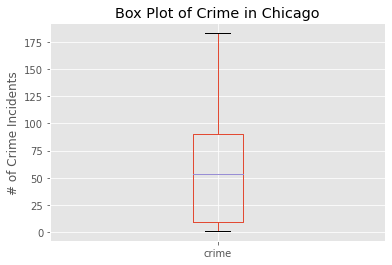

In [16]:
import matplotlib.pyplot as plt

crimeszip2['crime'].plot(kind = 'box', showfliers=False)
plt.title('Box Plot of Crime in Chicago')
plt.ylabel('# of Crime Incidents')

In [17]:
chicago_df['crimes'] = np.nan

chicago_df.crimes=chicago_df.zipcode.map(crimeszip2.set_index('zipcodefinal').crime)

chicago_df.head()

address   latitude  longitude  \
0                  2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                    2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2  Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3     620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4  2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   

    price    rooms                                            details zipcode  \
0  $1,950    2 bds    2322 N Southport Ave, Chicago, IL $1,950  2 bds   60614   
1  $1,200     1 bd       2566 N Lincoln Ave, Chicago, IL $1,200  1 bd   60614   
2  $1,735     1 bd  Roosevelt Collection Lofts | 1135 S Delano Ct,...   60605   
3    $925   Studio  620 W Belmont | 620 W Belmont Ave, Chicago, IL...   60613   
4    $955   Studio  2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...   60614   

   crimes  
0      61  
1      61  
2      43  
3      67  
4      61

In [18]:
chicago_df['No_of_crimes']=chicago_df['crimes']

chicago_df.head()

address   latitude  longitude  \
0                  2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                    2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2  Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3     620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4  2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   

    price    rooms                                            details zipcode  \
0  $1,950    2 bds    2322 N Southport Ave, Chicago, IL $1,950  2 bds   60614   
1  $1,200     1 bd       2566 N Lincoln Ave, Chicago, IL $1,200  1 bd   60614   
2  $1,735     1 bd  Roosevelt Collection Lofts | 1135 S Delano Ct,...   60605   
3    $925   Studio  620 W Belmont | 620 W Belmont Ave, Chicago, IL...   60613   
4    $955   Studio  2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...   60614   

   crimes  No_of_crimes  
0      61            61  
1      61            61  
2      43            43  
3      67            67  
4      61            61

In [19]:
chicago_df['price1']=chicago_df['price'].str.split("$").str[1]
chicago_df

address   latitude  longitude  \
0                    2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                      2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3       620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   
..                                                 ...        ...        ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...  41.929058 -87.643767   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...  41.877635 -87.658137   
210  North Park Pointe | 1552 N North Park Ave, Chi...  41.910847 -87.636722   
211          Logan | 2480 N Milwaukee Ave, Chicago, IL  41.926316 -87.703411   
212  Luxe on Chicago | 1838 W Chicago Ave, Chicago, IL  41.896113 -87.673155   

             price    rooms  \
0           $1,950    2 bds   
1           $1,200     1 bd   
2           $1,735     1 bd   
3             $925   Studio   
4             $955   Studio   
..             ...      ...   
208         $1,325   Studio   
209         $2,145     1 bd   
210         $2,013     1 bd   
211         $1,746     1 bd   
212  $1,750 Studio      NaN   

                                               details zipcode  crimes  \
0      2322 N Southport Ave, Chicago, IL $1,950  2 bds   60614      61   
1         2566 N Lincoln Ave, Chicago, IL $1,200  1 bd   60614      61   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...   60605      43   
3    620 W Belmont | 620 W Belmont Ave, Chicago, IL...   60613      67   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...   60614      61   
..                                                 ...     ...     ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...   60614      61   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...   60607      71   
210  North Park Pointe | 1552 N North Park Ave, Chi...   60610     101   
211  Logan | 2480 N Milwaukee Ave, Chicago, IL $1,7...   60647      96   
212                                                NaN   60642      53   

     No_of_crimes        price1  
0              61         1,950  
1              61         1,200  
2              43         1,735  
3              67           925  
4              61           955  
..            ...           ...  
208            61         1,325  
209            71         2,145  
210           101         2,013  
211            96         1,746  
212            53  1,750 Studio  

[213 rows x 10 columns]

In [20]:
chicago_df['price2']=chicago_df['price1'].str.split("S").str[0]
chicago_df

address   latitude  longitude  \
0                    2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                      2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3       620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   
..                                                 ...        ...        ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...  41.929058 -87.643767   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...  41.877635 -87.658137   
210  North Park Pointe | 1552 N North Park Ave, Chi...  41.910847 -87.636722   
211          Logan | 2480 N Milwaukee Ave, Chicago, IL  41.926316 -87.703411   
212  Luxe on Chicago | 1838 W Chicago Ave, Chicago, IL  41.896113 -87.673155   

             price    rooms  \
0           $1,950    2 bds   
1           $1,200     1 bd   
2           $1,735     1 bd   
3             $925   Studio   
4             $955   Studio   
..             ...      ...   
208         $1,325   Studio   
209         $2,145     1 bd   
210         $2,013     1 bd   
211         $1,746     1 bd   
212  $1,750 Studio      NaN   

                                               details zipcode  crimes  \
0      2322 N Southport Ave, Chicago, IL $1,950  2 bds   60614      61   
1         2566 N Lincoln Ave, Chicago, IL $1,200  1 bd   60614      61   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...   60605      43   
3    620 W Belmont | 620 W Belmont Ave, Chicago, IL...   60613      67   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...   60614      61   
..                                                 ...     ...     ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...   60614      61   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...   60607      71   
210  North Park Pointe | 1552 N North Park Ave, Chi...   60610     101   
211  Logan | 2480 N Milwaukee Ave, Chicago, IL $1,7...   60647      96   
212                                                NaN   60642      53   

     No_of_crimes        price1  price2  
0              61         1,950   1,950  
1              61         1,200   1,200  
2              43         1,735   1,735  
3              67           925     925  
4              61           955     955  
..            ...           ...     ...  
208            61         1,325   1,325  
209            71         2,145   2,145  
210           101         2,013   2,013  
211            96         1,746   1,746  
212            53  1,750 Studio  1,750   

[213 rows x 11 columns]

In [21]:
chicago_df['price2']=chicago_df.price2.str.replace(",",'')
chicago_df

address   latitude  longitude  \
0                    2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                      2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3       620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   
..                                                 ...        ...        ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...  41.929058 -87.643767   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...  41.877635 -87.658137   
210  North Park Pointe | 1552 N North Park Ave, Chi...  41.910847 -87.636722   
211          Logan | 2480 N Milwaukee Ave, Chicago, IL  41.926316 -87.703411   
212  Luxe on Chicago | 1838 W Chicago Ave, Chicago, IL  41.896113 -87.673155   

             price    rooms  \
0           $1,950    2 bds   
1           $1,200     1 bd   
2           $1,735     1 bd   
3             $925   Studio   
4             $955   Studio   
..             ...      ...   
208         $1,325   Studio   
209         $2,145     1 bd   
210         $2,013     1 bd   
211         $1,746     1 bd   
212  $1,750 Studio      NaN   

                                               details zipcode  crimes  \
0      2322 N Southport Ave, Chicago, IL $1,950  2 bds   60614      61   
1         2566 N Lincoln Ave, Chicago, IL $1,200  1 bd   60614      61   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...   60605      43   
3    620 W Belmont | 620 W Belmont Ave, Chicago, IL...   60613      67   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...   60614      61   
..                                                 ...     ...     ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...   60614      61   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...   60607      71   
210  North Park Pointe | 1552 N North Park Ave, Chi...   60610     101   
211  Logan | 2480 N Milwaukee Ave, Chicago, IL $1,7...   60647      96   
212                                                NaN   60642      53   

     No_of_crimes        price1 price2  
0              61         1,950   1950  
1              61         1,200   1200  
2              43         1,735   1735  
3              67           925    925  
4              61           955    955  
..            ...           ...    ...  
208            61         1,325   1325  
209            71         2,145   2145  
210           101         2,013   2013  
211            96         1,746   1746  
212            53  1,750 Studio  1750   

[213 rows x 11 columns]

In [22]:
chicago_df['price3']=chicago_df['price2'].str.split(" ").str[0]
chicago_df

address   latitude  longitude  \
0                    2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                      2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3       620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   
..                                                 ...        ...        ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...  41.929058 -87.643767   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...  41.877635 -87.658137   
210  North Park Pointe | 1552 N North Park Ave, Chi...  41.910847 -87.636722   
211          Logan | 2480 N Milwaukee Ave, Chicago, IL  41.926316 -87.703411   
212  Luxe on Chicago | 1838 W Chicago Ave, Chicago, IL  41.896113 -87.673155   

             price    rooms  \
0           $1,950    2 bds   
1           $1,200     1 bd   
2           $1,735     1 bd   
3             $925   Studio   
4             $955   Studio   
..             ...      ...   
208         $1,325   Studio   
209         $2,145     1 bd   
210         $2,013     1 bd   
211         $1,746     1 bd   
212  $1,750 Studio      NaN   

                                               details zipcode  crimes  \
0      2322 N Southport Ave, Chicago, IL $1,950  2 bds   60614      61   
1         2566 N Lincoln Ave, Chicago, IL $1,200  1 bd   60614      61   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...   60605      43   
3    620 W Belmont | 620 W Belmont Ave, Chicago, IL...   60613      67   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...   60614      61   
..                                                 ...     ...     ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...   60614      61   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...   60607      71   
210  North Park Pointe | 1552 N North Park Ave, Chi...   60610     101   
211  Logan | 2480 N Milwaukee Ave, Chicago, IL $1,7...   60647      96   
212                                                NaN   60642      53   

     No_of_crimes        price1 price2 price3  
0              61         1,950   1950   1950  
1              61         1,200   1200   1200  
2              43         1,735   1735   1735  
3              67           925    925    925  
4              61           955    955    955  
..            ...           ...    ...    ...  
208            61         1,325   1325   1325  
209            71         2,145   2145   2145  
210           101         2,013   2013   2013  
211            96         1,746   1746   1746  
212            53  1,750 Studio  1750    1750  

[213 rows x 12 columns]

In [23]:

chicago_df['price4'] = chicago_df['price3'].astype(float).round(0)
chicago_df

address   latitude  longitude  \
0                    2322 N Southport Ave, Chicago, IL  41.924141 -87.663269   
1                      2566 N Lincoln Ave, Chicago, IL  41.928434 -87.653391   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...  41.867458 -87.632553   
3       620 W Belmont | 620 W Belmont Ave, Chicago, IL  41.940342 -87.645688   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...  41.919770 -87.638550   
..                                                 ...        ...        ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...  41.929058 -87.643767   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...  41.877635 -87.658137   
210  North Park Pointe | 1552 N North Park Ave, Chi...  41.910847 -87.636722   
211          Logan | 2480 N Milwaukee Ave, Chicago, IL  41.926316 -87.703411   
212  Luxe on Chicago | 1838 W Chicago Ave, Chicago, IL  41.896113 -87.673155   

             price    rooms  \
0           $1,950    2 bds   
1           $1,200     1 bd   
2           $1,735     1 bd   
3             $925   Studio   
4             $955   Studio   
..             ...      ...   
208         $1,325   Studio   
209         $2,145     1 bd   
210         $2,013     1 bd   
211         $1,746     1 bd   
212  $1,750 Studio      NaN   

                                               details zipcode  crimes  \
0      2322 N Southport Ave, Chicago, IL $1,950  2 bds   60614      61   
1         2566 N Lincoln Ave, Chicago, IL $1,200  1 bd   60614      61   
2    Roosevelt Collection Lofts | 1135 S Delano Ct,...   60605      43   
3    620 W Belmont | 620 W Belmont Ave, Chicago, IL...   60613      67   
4    2051 N. Sedgwick | 2051 N Sedgwick St, Chicago...   60614      61   
..                                                 ...     ...     ...   
208  625 W Wrightwood | 625 W Wrightwood Ave, Chica...   60614      61   
209  Reside on Jackson | 1245 W Jackson Blvd, Chica...   60607      71   
210  North Park Pointe | 1552 N North Park Ave, Chi...   60610     101   
211  Logan | 2480 N Milwaukee Ave, Chicago, IL $1,7...   60647      96   
212                                                NaN   60642      53   

     No_of_crimes        price1 price2 price3  price4  
0              61         1,950   1950   1950  1950.0  
1              61         1,200   1200   1200  1200.0  
2              43         1,735   1735   1735  1735.0  
3              67           925    925    925   925.0  
4              61           955    955    955   955.0  
..            ...           ...    ...    ...     ...  
208            61         1,325   1325   1325  1325.0  
209            71         2,145   2145   2145  2145.0  
210           101         2,013   2013   2013  2013.0  
211            96         1,746   1746   1746  1746.0  
212            53  1,750 Studio  1750    1750  1750.0  

[213 rows x 13 columns]

In [24]:
!pip install folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium as folium # map rendering library

# from folium.plugins import MarkerCluster

In [25]:
#Display map for apartment locations including price
chicago_map = folium.Map(location=(41.895140898, -87.624255632), zoom_start=10)

#add markers to map

for lat, lng, label in zip(chicago_df['latitude'], chicago_df['longitude'], chicago_df['details']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chicago_map)  
    
chicago_map  

In [26]:

from folium import plugins
# let's start again with a clean copy of the map of San Francisco
latitude = 41.895140898
longitude = -87.624255632

chicago_crimes = folium.Map(location = [latitude, longitude], zoom_start = 12)


#create map and display it

# chicago_crimes = folium.Map(location=(41.895140898, -87.624255632), zoom_start=10)


# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(chicago_crimes)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(crimes.lat, crimes.lon, crimes.Description):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
chicago_crimes

In [27]:
#create map to display apartments with levels of crime (High = Red, Medium = Yellow, Green = Low)

chicago_rental = folium.Map(location = [41.895140898, -87.624255632], zoom_start = 10)
for lat, lng, details, zipcode, crimes in zip(chicago_df['latitude'], chicago_df['longitude'], chicago_df['details'], chicago_df['zipcode'], chicago_df['No_of_crimes']):
    label = 'About: {} \n Zipcode: {} \n Crime: {}'.format(details, zipcode, crimes)
    label = folium.Popup(label, parse_html = True)
    if int(crimes) < 50:
        color="green" 
    elif int(crimes) >  80:
        color = "red"
    else: 
        color="yellow"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(chicago_rental)
    
chicago_rental

price4  No_of_crimes
price4        1.000000     -0.273994
No_of_crimes -0.273994      1.000000

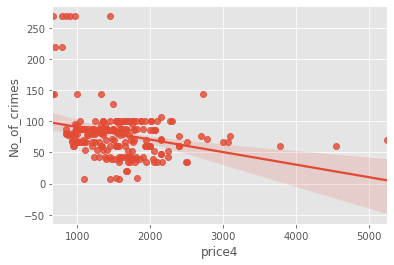

In [28]:
#graph correlation
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x="price4", y="No_of_crimes", data=chicago_df)
chicago_df[["price4", "No_of_crimes"]].corr()

In [30]:
chicago_df[["No_of_crimes","price4"]].corr() 

No_of_crimes    price4
No_of_crimes      1.000000 -0.273994
price4           -0.273994  1.000000

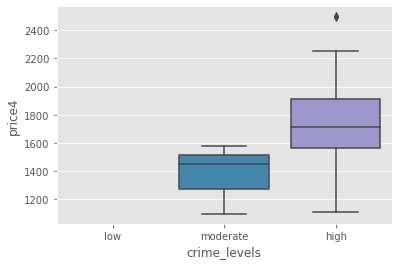

In [31]:
#display relationship between crime levels and apartment rental price

chicago_df['crime_levels'] = pd.cut(chicago_df['No_of_crimes'], [-1, 2,8,60], labels=['low', 'moderate', 'high'])
chicago_df
# to create label for your crime levels
sns.boxplot(x="crime_levels", y="price4", data=chicago_df)

## Analysis <a name="analysis"></a>

Map Data

After evaluating the crime rates of different postal codes we then obtained kid friendly actiities within a mile of the post codes. Further clustering the results in order to get the most family-friendly neigborhoods based on all of our criteria.

The results suggest there are many family-friendly neighborhoods to choose from. Which is great news as many people believe it is impossible to find family-friendly neighborhoods in Big Cities. There are 136 family-friendly Postal Codes located all across London. So stakeholders would not have a problem finding the right neighborhood based on their own preferences,needs & budget.

It should be noted that some of the neighborhoods ranked as the safest do not have many identified kid-friendly activities. But some stakeholders may find this as helpful information because it would be a prime location to open/build kid friendly venues to attract new families to the neighborhood and solve a problem for the families already living there. 